# mini-BERT Pretrain Project
한글 위키 데이터를 이용한 BERT 사전학습 프로젝트  

목차:  
1. 

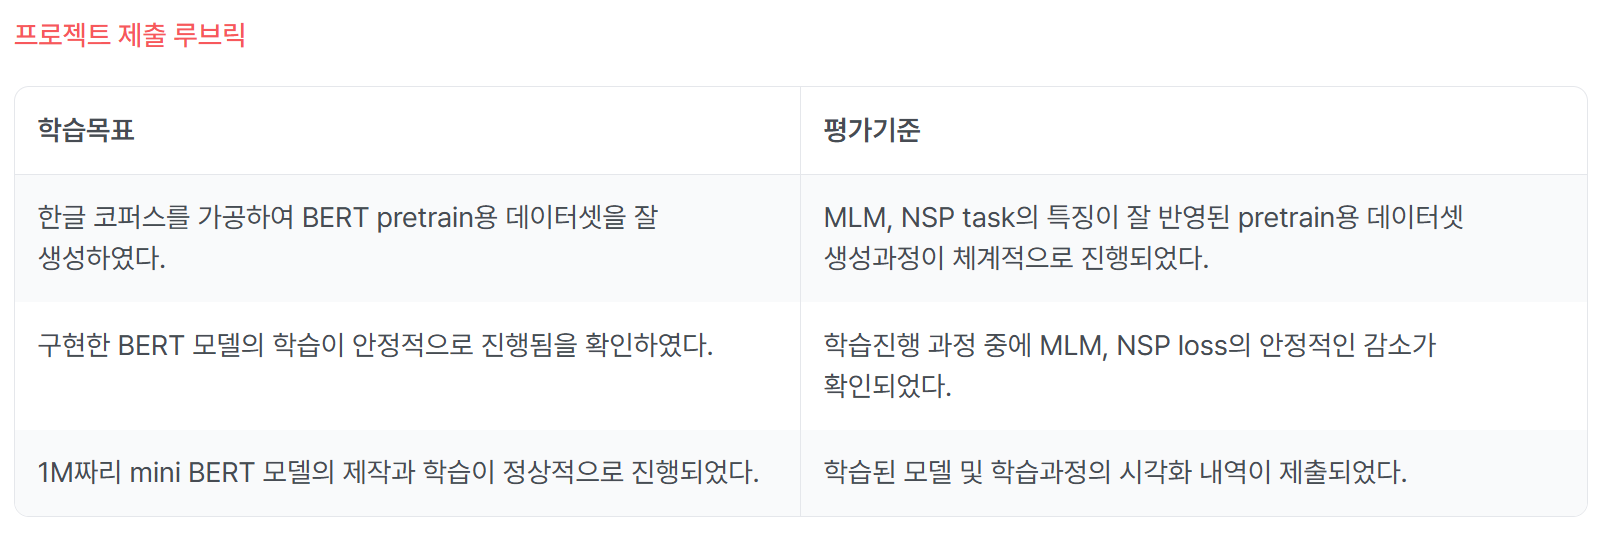

# Section 1. 설정 (config)
1. 라이브러리 로드
2. 시드 고정
3. cofig

In [4]:
!pip install kss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 49.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 MB 12.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 45.6 MB/s eta 0:00:00
  DEPRECATION: Building 'kss' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pypro

In [5]:
import os
import json
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import sentencepiece as spm
import kss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, random_split

In [6]:
# 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 설정
CONFIG = {
    # 경로 설정
    "data_dir": "data",
    "corpus_file": "data/kowiki.txt",
    "processed_file": "data/bert_pretrain.json",
    "cleaned_file": "data/kowiki_cleaned.txt",
    "result_file": "models/ablation_results.csv",
    "tokenizer_dir": "tokenizers",
    "model_dir": "models",
    "corpus_file": "data/kowiki.txt",
    "tokenizer_prefix": "tokenizers/ko_8000",

    # 모델 하이퍼파라미터
    "d_model": 256,
    "n_layers": 6,
    "n_heads": 8,
    "d_ff": 1024,
    "dropout": 0.1,

    # 학습 설정
    "vocab_size": 8000,
    "max_len": 128,
    "mask_prob": 0.15,
    "batch_size": 32,
    "epochs": 50,
    "patience": 10,
    "learning_rate": 1e-4,
    "warmup_steps": 1000,
    "train_split": 0.9, 
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "use_amp": True 
}

# 디렉토리 생성
os.makedirs(CONFIG["data_dir"], exist_ok=True)
os.makedirs(CONFIG["tokenizer_dir"], exist_ok=True)
os.makedirs(CONFIG["model_dir"], exist_ok=True)

print(f"Device: {CONFIG['device']}")
print(f"Config: {json.dumps(CONFIG, indent=2, ensure_ascii=False)}")

Device: cuda
Config: {
  "data_dir": "data",
  "corpus_file": "data/kowiki.txt",
  "processed_file": "data/bert_pretrain.json",
  "cleaned_file": "data/kowiki_cleaned.txt",
  "result_file": "models/ablation_results.csv",
  "tokenizer_dir": "tokenizers",
  "model_dir": "models",
  "tokenizer_prefix": "tokenizers/ko_8000",
  "d_model": 256,
  "n_layers": 6,
  "n_heads": 8,
  "d_ff": 1024,
  "dropout": 0.1,
  "vocab_size": 8000,
  "max_len": 128,
  "mask_prob": 0.15,
  "batch_size": 32,
  "epochs": 50,
  "patience": 10,
  "learning_rate": 0.0001,
  "warmup_steps": 1000,
  "train_split": 0.9,
  "device": "cuda",
  "use_amp": true
}


# Section 2. 함수 정의

## Section 2.1 토크나이저
1. SentencePiece 토크나이저 학습
2. 토크나이저 로드

In [7]:
def train_sentencepiece(corpus_file, prefix, target_vocab_size):
    """SentencePiece 모델 학습"""
    # 이미 존재하면 스킵
    if os.path.exists(f"{prefix}.model"):
        print(f"토크나이저가 이미 존재합니다: {prefix}.model")
        return

    print("SentencePiece 토크나이저 학습 시작...")
    # 특수 토큰 7개를 제외한 순수 단어 개수 계산
    # 특수 토큰: unk, bos, eos (기본 3개) + cls, sep, mask, pad (추가 4개)
    input_vocab_arg = target_vocab_size - 7

    spm.SentencePieceTrainer.train(
        input=corpus_file,
        model_prefix=prefix,
        vocab_size=input_vocab_arg,
        character_coverage=0.9995,
        model_type='bpe',
        pad_id=0, unk_id=1, bos_id=2, eos_id=3,
        user_defined_symbols=['[CLS]', '[SEP]', '[MASK]', '[PAD]'],
        input_sentence_size=10000000,
        shuffle_input_sentence=True
    )
    print("토크나이저 학습 완료")


def load_tokenizer(model_path):
    sp = spm.SentencePieceProcessor()
    sp.load(model_path)
    return sp

## Section 2.2 데이터 전처리
1. 마스크 생성 (Whole Word Masking 적용)
2. 길이 초과 시 토큰 잘라내기
3. 문서별 pretrain 데이터 인스턴스 생성
4. 메인 전처리 함수

In [8]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성 (Whole Word Masking 적용)
    """
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        # SentencePiece의 언더바(_)로 시작하면 새로운 단어의 시작
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    random.shuffle(cand_idx)
    mask_lms = []
    
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
            
        dice = random.random()
        for index in index_set:
            masked_token = None
            # 80% 확률로 [MASK]
            if dice < 0.8:
                masked_token = "[MASK]"
            # 10% 확률로 원본 유지
            elif dice < 0.9:
                masked_token = tokens[index]
            # 10% 확률로 랜덤 단어
            else:
                masked_token = random.choice(vocab_list)
                
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

def trim_tokens(tokens_a, tokens_b, max_seq):
    """길이 초과 시 토큰 잘라내기"""
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break
        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """문서별 pretrain 데이터 인스턴스 생성"""
    max_seq = n_seq - 3
    instances = []
    current_chunk = []
    current_length = 0
    
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            # SOP (Sentence Order Prediction)
            if random.random() < 0.5:
                is_next = 0 # 순서 바뀜 (False)
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1 # 순서 유지 (True)
            
            trim_tokens(tokens_a, tokens_b, max_seq)
            
            if len(tokens_a) == 0 or len(tokens_b) == 0:
                continue
                
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            
            # Masking 적용
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
            
    return instances

def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """메인 전처리 함수: 파일 읽기 -> 문장 분리 -> 인스턴스 생성 -> 저장"""
    
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 랜덤 마스킹용 Vocab List 생성 (특수 토큰 제외)
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # 라인 수 계산 (진행률 표시용)
    line_cnt = 0
    with open(in_file, "r", encoding='utf-8') as in_f:
        for _ in in_f: line_cnt += 1

    print(f"데이터 생성 시작: {in_file} -> {out_file}")
    
    with open(in_file, "r", encoding='utf-8') as in_f:
        with open(out_file, "w", encoding='utf-8') as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt, desc="Preprocessing"):
                line = line.strip()
                
                # 빈 줄은 문서의 경계로 인식
                if line == "":
                    if len(doc) > 0:
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:
                    # KSS 문장 분리 적용
                    try:
                        sentences = kss.split_sentences(line)
                    except:
                        sentences = [line]

                    for sent in sentences:
                        pieces = vocab.encode_as_pieces(sent)
                        if len(pieces) > 0:
                            doc.append(pieces)
                            
            if len(doc) > 0:
                save_pretrain_instances(out_f, doc)

    print("전처리 완료")

In [8]:
class TransformerEncoderLayer(nn.Module):
    """Pre-LayerNorm Transformer Encoder Layer"""
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        norm_x = self.norm1(x)
        attn_output = self.attention(norm_x, norm_x, norm_x, mask)
        x = x + self.dropout1(attn_output)
        
        norm_x = self.norm2(x)
        ff_output = self.feed_forward(norm_x)
        x = x + self.dropout2(ff_output)
        
        return x

class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, dropout):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.position_emb = nn.Embedding(max_len, d_model)
        self.segment_emb = nn.Embedding(2, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, segment_ids):
        batch_size, seq_len = x.size()
        pos = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        embedding = self.token_emb(x) + self.position_emb(pos) + self.segment_emb(segment_ids)
        return self.dropout(self.norm(embedding))

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        Q = self.W_q(q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e4)
        attn = self.dropout(F.softmax(scores, dim=-1))
        context = torch.matmul(attn, V).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(context)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(gelu(self.linear1(x))))

class BERT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout):
        super().__init__()
        self.embedding = BERTEmbedding(vocab_size, d_model, max_len, dropout)
        self.layers = nn.ModuleList([TransformerEncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        # Pre-LayerNorm의 경우 마지막에 Norm 추가가 일반적
        self.final_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, segment_ids, mask):
        x = self.embedding(x, segment_ids)
        for layer in self.layers:
            x = layer(x, mask)
        return self.final_norm(x)

class BERTForPretraining(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout):
        super().__init__()
        self.bert = BERT(vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout)
        self.mlm_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, vocab_size)
        )
        self.nsp_head = nn.Linear(d_model, 2)
        
    def forward(self, input_ids, segment_ids, attention_mask):
        encoded = self.bert(input_ids, segment_ids, attention_mask)
        mlm_logits = self.mlm_head(encoded)
        nsp_logits = self.nsp_head(encoded[:, 0])
        return mlm_logits, nsp_logits

## Section 2.3 Dataset & Dynamic Masking Collator
1. 데이터 로드
2. 이미 마스킹된 데이터셋의 배치를 받아 패딩(Padding)을 수행

In [9]:
class PretrainDataset(Dataset):
    """
    JSON 파일에서 데이터를 로드합니다.
    이미 전처리가 완료된 상태이므로, 토큰 문자열을 ID로 변환하는 작업만 수행합니다.
    """
    def __init__(self, path, vocab):
        self.vocab = vocab
        self.data = []
        
        print(f"데이터셋 로드 중: {path}")
        with open(path, "r", encoding="utf-8") as f:
            for line in tqdm(f, desc="Loading JSON"):
                self.data.append(json.loads(line))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        item = self.data[i]
        
        # Token Strings -> Token IDs
        input_ids = [self.vocab.piece_to_id(p) for p in item["tokens"]]
        segment_ids = item["segment"]
        
        # MLM Labels 생성
        # 전체를 -100으로 채우고, 마스킹된 위치만 정답 ID로 채움
        mlm_labels = [-100] * len(input_ids)
        for idx, label_str in zip(item["mask_idx"], item["mask_label"]):
            mlm_labels[idx] = self.vocab.piece_to_id(label_str)
            
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "segment_ids": torch.tensor(segment_ids, dtype=torch.long),
            "mlm_labels": torch.tensor(mlm_labels, dtype=torch.long),
            "nsp_label": torch.tensor(item["is_next"], dtype=torch.long)
        }

class StaticDataCollator:
    """
    이미 마스킹된 데이터셋의 배치를 받아 패딩(Padding)을 수행합니다.
    """
    def __init__(self, pad_id):
        self.pad_id = pad_id

    def __call__(self, batch):
        # 가장 긴 시퀀스 길이 찾기
        max_len = max([len(b["input_ids"]) for b in batch])
        
        input_ids_batch = []
        segment_ids_batch = []
        mlm_labels_batch = []
        nsp_labels_batch = []
        attention_mask_batch = []
        
        for b in batch:
            input_ids = b["input_ids"]
            segment_ids = b["segment_ids"]
            mlm_labels = b["mlm_labels"]
            
            pad_len = max_len - len(input_ids)
            
            # Padding 적용
            input_ids = F.pad(input_ids, (0, pad_len), value=self.pad_id)
            segment_ids = F.pad(segment_ids, (0, pad_len), value=0)
            mlm_labels = F.pad(mlm_labels, (0, pad_len), value=-100)
            
            # Attention Mask (Padding 부분은 0)
            attention_mask = (input_ids != self.pad_id).long()
            
            input_ids_batch.append(input_ids)
            segment_ids_batch.append(segment_ids)
            mlm_labels_batch.append(mlm_labels)
            attention_mask_batch.append(attention_mask)
            nsp_labels_batch.append(b["nsp_label"])
            
        return {
            "input_ids": torch.stack(input_ids_batch),
            "segment_ids": torch.stack(segment_ids_batch),
            "mlm_labels": torch.stack(mlm_labels_batch),
            "attention_mask": torch.stack(attention_mask_batch),
            "nsp_labels": torch.stack(nsp_labels_batch)
        }

## Section 2.4 모델 구현
1. GeLU
2. Multi-Head Attention
3. Feed-Forward Network
4. Transformer Encoder Layer
5. BERT Model
6. BERT for Pretraining

In [10]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / np.sqrt(2.0)))

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        Q = self.W_q(q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            # AMP 안전장치: -1e9 대신 -1e4 사용
            scores = scores.masked_fill(mask == 0, -1e4)
            
        attn = self.dropout(F.softmax(scores, dim=-1))
        context = torch.matmul(attn, V).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(context)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.linear2(self.dropout(gelu(self.linear1(x))))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    def forward(self, x, mask):
        x = x + self.dropout1(self.attention(self.norm1(x), self.norm1(x), self.norm1(x), mask))
        x = x + self.dropout2(self.feed_forward(self.norm2(x)))
        return x

class BERT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.position_emb = nn.Embedding(max_len, d_model)
        self.segment_emb = nn.Embedding(2, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.layers = nn.ModuleList([TransformerEncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.final_norm = nn.LayerNorm(d_model)
    def forward(self, x, segment_ids, mask):
        pos = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        x = self.dropout(self.norm(self.token_emb(x) + self.position_emb(pos) + self.segment_emb(segment_ids)))
        for layer in self.layers:
            x = layer(x, mask)
        return self.final_norm(x)

class BERTForPretraining(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout):
        super().__init__()
        self.bert = BERT(vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout)
        self.mlm_head = nn.Sequential(
            nn.Linear(d_model, d_model), nn.GELU(), nn.LayerNorm(d_model), nn.Linear(d_model, vocab_size)
        )
        self.nsp_head = nn.Linear(d_model, 2)
    def forward(self, input_ids, segment_ids, attention_mask):
        encoded = self.bert(input_ids, segment_ids, attention_mask)
        return self.mlm_head(encoded), self.nsp_head(encoded[:, 0])

## Section 2.5 학습 유틸리티 및 루프
1. 조기 종료
2. metric 기록
3. 학습
4. 검증

In [11]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=True, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def save_ablation_result(val_loss, mlm_acc, nsp_acc, file_path):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        next_id = df['Ablation_ID'].max() + 1 if not df.empty else 1
    else:
        df = pd.DataFrame(columns=['Ablation_ID', 'Val_Loss', 'MLM_Acc', 'NSP_Acc'])
        next_id = 1
    
    new_data = {
        'Ablation_ID': [next_id],
        'Val_Loss': [round(val_loss, 6)],
        'MLM_Acc': [round(mlm_acc, 4)],
        'NSP_Acc': [round(nsp_acc, 4)]
    }
    pd.concat([df, pd.DataFrame(new_data)], ignore_index=True).to_csv(file_path, index=False)
    print(f"결과 저장 완료: {file_path}")

def train_epoch(model, dataloader, optimizer, scheduler, scaler, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        segment_ids = batch['segment_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device).unsqueeze(1).unsqueeze(2)
        mlm_labels = batch['mlm_labels'].to(device)
        nsp_labels = batch['nsp_labels'].to(device)
        
        with autocast(enabled=CONFIG["use_amp"]):
            mlm_logits, nsp_logits = model(input_ids, segment_ids, attention_mask)
            mlm_loss = F.cross_entropy(mlm_logits.view(-1, CONFIG['vocab_size']), mlm_labels.view(-1), ignore_index=-100)
            nsp_loss = F.cross_entropy(nsp_logits, nsp_labels)
            loss = mlm_loss + nsp_loss
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    mlm_correct = mlm_total = 0
    nsp_correct = nsp_total = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            segment_ids = batch['segment_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device).unsqueeze(1).unsqueeze(2)
            mlm_labels = batch['mlm_labels'].to(device)
            nsp_labels = batch['nsp_labels'].to(device)
            
            mlm_logits, nsp_logits = model(input_ids, segment_ids, attention_mask)
            
            # Loss
            mlm_loss = F.cross_entropy(mlm_logits.view(-1, CONFIG['vocab_size']), mlm_labels.view(-1), ignore_index=-100)
            nsp_loss = F.cross_entropy(nsp_logits, nsp_labels)
            total_loss += (mlm_loss + nsp_loss).item()
            
            # Accuracy
            mlm_preds = mlm_logits.argmax(dim=-1)
            mask_indices = (mlm_labels != -100)
            mlm_correct += (mlm_preds[mask_indices] == mlm_labels[mask_indices]).sum().item()
            mlm_total += mask_indices.sum().item()
            
            nsp_correct += (nsp_logits.argmax(dim=-1) == nsp_labels).sum().item()
            nsp_total += len(nsp_labels)
            
    avg_loss = total_loss / len(dataloader)
    mlm_acc = mlm_correct / max(1, mlm_total)
    nsp_acc = nsp_correct / max(1, nsp_total)
    
    return avg_loss, mlm_acc, nsp_acc

# Section 3. EDA

# Section 3. Tokenizer & Dataset 준비

In [ ]:
# 토크나이저 학습/로드
train_sentencepiece(CONFIG["cleaned_file"], CONFIG["tokenizer_prefix"], CONFIG["vocab_size"])
tokenizer, special_tokens = load_tokenizer(f"{CONFIG['tokenizer_prefix']}.model")

# 데이터셋 생성
dataset_file = "data/pretrain_data_cleaned.json"
if not os.path.exists(dataset_file):
    dataset_raw = create_pretrain_dataset(CONFIG["cleaned_file"], dataset_file, tokenizer, special_tokens, CONFIG["max_len"])
else:
    print(f"기존 데이터셋 로드: {dataset_file}")
    with open(dataset_file, 'r', encoding='utf-8') as f:
        dataset_raw = json.load(f)

토크나이저가 이미 존재합니다: tokenizers/ko_8000.model
기존 데이터셋 로드: data/pretrain_data_cleaned.json


# Section 4. DataLoader 생성

In [ ]:
full_dataset = BERTDataset(dataset_raw)
train_size = int(len(full_dataset) * CONFIG["train_split"])
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

collator = DynamicMaskingCollator(tokenizer, CONFIG["mask_prob"], CONFIG["vocab_size"], special_tokens)
train_loader = DataLoader(train_set, batch_size=CONFIG["batch_size"], shuffle=True, collate_fn=collator)
val_loader = DataLoader(val_set, batch_size=CONFIG["batch_size"], shuffle=False, collate_fn=collator)

print(f"Train Batches: {len(train_loader)}")
print(f"Val Batches:   {len(val_loader)}")
print("DataLoader 생성 완료!")

# Section 5. 모델 초기화

In [ ]:
model = BERTForPretraining(
    vocab_size=CONFIG["vocab_size"], d_model=CONFIG["d_model"], n_layers=CONFIG["n_layers"],
    n_heads=CONFIG["n_heads"], d_ff=CONFIG["d_ff"], max_len=CONFIG["max_len"], dropout=CONFIG["dropout"]
).to(CONFIG["device"])

print(f"전체 파라미터 수: {count_parameters(model):,}")
print(f"디바이스: {CONFIG["device"]}")

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"])
scaler = torch.amp.GradScaler('cuda', enabled=CONFIG["use_amp"])
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=CONFIG["warmup_steps"])

early_stopping = EarlyStopping(patience=CONFIG["patience"], verbose=True, path=f"{CONFIG['model_dir']}/bert_best.pt")

# Section 6. 모델 학습

In [ ]:
history = {'train_loss': [], 'val_loss': [], 'mlm_acc': [], 'nsp_acc': []}

best_val_loss = float('inf')
best_mlm_acc = 0.0
best_nsp_acc = 0.0

print(f"\n학습 시작! (Train: {len(train_set)}, Val: {len(val_set)})")
print("Early Stopping & Ablation Logging 적용")

for epoch in range(CONFIG["epochs"]):
    print(f"\n{'='*30} Epoch {epoch + 1}/{CONFIG['epochs']} {'='*30}")
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, CONFIG["device"])
    val_loss, mlm_acc, nsp_acc = validate_epoch(model, val_loader, CONFIG["device"])
    
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['mlm_acc'].append(mlm_acc); history['nsp_acc'].append(nsp_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"MLM Acc: {mlm_acc:.4f} | NSP Acc: {nsp_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_mlm_acc = mlm_acc
        best_nsp_acc = nsp_acc
    
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("\n[알림] Early stopping triggered! 학습을 조기 종료합니다.")
        break
        
print("\n학습 종료. 가장 성능이 좋은 모델은 'models/bert_best.pt'에 저장되었습니다.")

# Section 7. 결과 시각화

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve'); plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['mlm_acc'], 'g-o')
plt.title('Validation MLM Accuracy')

plt.subplot(1, 3, 3)
plt.plot(history['nsp_acc'], 'r-o')
plt.title('Validation NSP Accuracy')

plt.tight_layout()
plt.savefig(f"{CONFIG['model_dir']}/training_history_earlystop.png")
plt.show()